In [3]:
import scanpy as sc
import pertpy as pt
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## pseudobulk to cell_line and treatment only
from adpbulk import ADPBulk

In [2]:
pb_path = "/home/ubuntu/frameshift-1/data/20250213.Tahoe.merged.pseudobulk.public.h5ad"
# adata = sc.read_h5ad(pb_path, backed='r')
adata = sc.read_h5ad(pb_path)
adata

AnnData object with n_obs × n_vars = 67018 × 62710
    obs: 'sample', 'drugname_drugconc', 'drug', 'n_cells', 'tscp_count', 'plate', 'Cell_Name_Vevo', 'Cell_ID_Cellosaur'
    var: 'gene_id', 'genome'

In [4]:
# initialize the object
adpb = ADPBulk(adata, ["Cell_Name_Vevo", "drugname_drugconc"])

# perform the pseudobulking
pseudobulk_matrix = adpb.fit_transform()

# retrieve the sample meta data (useful for easy incorporation with edgeR)
sample_meta = adpb.get_meta()

pb = sc.AnnData(X=pseudobulk_matrix, obs=sample_meta.set_index('SampleName'))
pb

Aggregating Samples: 100%|██████████| 56900/56900 [00:30<00:00, 1863.03it/s]


AnnData object with n_obs × n_vars = 56877 × 62710
    obs: 'Cell_Name_Vevo', 'drugname_drugconc'

In [5]:
sc.pp.normalize_total(pb, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(pb)

In [ ]:
# distance = pt.tl.Distance("mse", groupby)
# df = distance.pairwise(adata, groupby=obs_key)

In [6]:
#get tools to compute MSE
import numpy as np
import pandas as pd
import scipy.stats as stats

mse = {}

gp = pb.obs.groupby('Cell_Name_Vevo')

control = "[('DMSO_TF', 0.0, 'uM')]"
for name, group in gp:
	control_idx = group[group['drugname_drugconc'] == control].index
	control_vec = pb[control_idx].X
	if control_vec.shape[0] != 1:
		print(group[group['drugname_drugconc'] == control])
	else:
		#get MSE values
		drug_idx = group[group['drugname_drugconc'] != control].index
		drug_vec = pb[drug_idx].X
		drug_names = group.loc[drug_idx, 'drugname_drugconc'].values
		#compute MSE
		mse_matr = drug_vec - control_vec
		mse_matr = np.square(mse_matr)
		mse_matr = np.mean(mse_matr, axis=1)
		mse[name] = pd.Series(mse_matr, index=drug_names)


	# control_idx = group[group['drugname_drugconc'] == control].index
	# if len(control_idx) == 0:
	# 	continue
	# for drug in group['drugname_drugconc'].unique():
	# 	if drug == control:
	# 		continue
	# 	#compute MSE for all treatments against DMSO
	# 	drug_idx

	# subdata = adata[group.index]

	# #compute MSE for all treatments against DMSO
	
	# break

In [7]:
msedf = pd.DataFrame(mse).T
msedf.head()

,"[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]","[('(R)-Verapamil (hydrochloride)', 0.5, 'uM')]","[('(R)-Verapamil (hydrochloride)', 5.0, 'uM')]","[('(S)-Crizotinib', 0.05, 'uM')]","[('(S)-Crizotinib', 0.5, 'uM')]","[('(S)-Crizotinib', 5.0, 'uM')]","[('18β-Glycyrrhetinic acid', 0.05, 'uM')]","[('18β-Glycyrrhetinic acid', 0.5, 'uM')]","[('18β-Glycyrrhetinic acid', 5.0, 'uM')]","[('4EGI-1', 0.05, 'uM')]",...,"[('palbociclib', 5.0, 'uM')]","[('venetoclax', 0.05, 'uM')]","[('venetoclax', 0.5, 'uM')]","[('venetoclax', 5.0, 'uM')]","[('vincristine', 0.05, 'uM')]","[('vincristine', 0.5, 'uM')]","[('vincristine', 5.0, 'uM')]","[('γ-Oryzanol', 0.05, 'uM')]","[('γ-Oryzanol', 0.5, 'uM')]","[('γ-Oryzanol', 5.0, 'uM')]"
A-172,0.018174,0.032850,0.011552,0.043094,0.036214,0.053174,0.027324,0.040055,0.015324,0.028687,...,0.056639,0.029429,0.019917,0.099251,0.032088,0.062579,0.093449,0.035522,0.055435,0.032061
A-427,0.019376,0.037314,0.013316,0.031679,0.024178,0.040300,0.028942,0.040082,0.018293,0.029539,...,0.076688,0.035632,0.027858,0.199012,0.039262,0.069874,0.085161,0.023355,0.044882,0.021820
A498,0.017212,0.030332,0.010586,0.032875,0.017455,0.026621,0.023062,0.034599,0.014778,0.028941,...,0.066754,0.027833,0.019773,0.104047,0.025987,0.047899,0.067847,0.017374,0.030468,0.016633
A549,0.022554,0.044229,0.013013,0.040690,0.026292,0.043222,0.031251,0.053505,0.017587,0.031560,...,0.073827,0.034707,0.018787,0.150167,0.028995,0.065889,0.112630,0.026248,0.043891,0.024085
AN3 CA,0.065111,0.153561,0.041375,0.133416,0.098233,0.136996,0.136618,0.178433,0.061750,0.125665,...,0.217747,0.094171,0.066787,0.276063,0.143620,0.192702,0.303217,0.108954,0.201124,0.079626


In [ ]:
msedf.median(axis=0).sort_values(ascending=False).head(20)

In [8]:
msedf.to_csv("/home/ubuntu/frameshift-1/data/MSE.tsv", sep="\t", header=True, index=True)

In [4]:
msedf = pd.read_csv("/home/ubuntu/frameshift-1/data/MSE.tsv", sep="\t", header=0, index_col=0)
msedf.head(2)

,"[('(R)-Verapamil (hydrochloride)', 0.05, 'uM')]","[('(R)-Verapamil (hydrochloride)', 0.5, 'uM')]","[('(R)-Verapamil (hydrochloride)', 5.0, 'uM')]","[('(S)-Crizotinib', 0.05, 'uM')]","[('(S)-Crizotinib', 0.5, 'uM')]","[('(S)-Crizotinib', 5.0, 'uM')]","[('18β-Glycyrrhetinic acid', 0.05, 'uM')]","[('18β-Glycyrrhetinic acid', 0.5, 'uM')]","[('18β-Glycyrrhetinic acid', 5.0, 'uM')]","[('4EGI-1', 0.05, 'uM')]",...,"[('palbociclib', 5.0, 'uM')]","[('venetoclax', 0.05, 'uM')]","[('venetoclax', 0.5, 'uM')]","[('venetoclax', 5.0, 'uM')]","[('vincristine', 0.05, 'uM')]","[('vincristine', 0.5, 'uM')]","[('vincristine', 5.0, 'uM')]","[('γ-Oryzanol', 0.05, 'uM')]","[('γ-Oryzanol', 0.5, 'uM')]","[('γ-Oryzanol', 5.0, 'uM')]"
A-172,0.018174,0.032850,0.011552,0.043094,0.036214,0.053174,0.027324,0.040055,0.015324,0.028687,...,0.056639,0.029429,0.019917,0.099251,0.032088,0.062579,0.093449,0.035522,0.055435,0.032061
A-427,0.019376,0.037314,0.013316,0.031679,0.024178,0.040300,0.028942,0.040082,0.018293,0.029539,...,0.076688,0.035632,0.027858,0.199012,0.039262,0.069874,0.085161,0.023355,0.044882,0.021820


In [5]:
picked_drugs = ["[('Adagrasib', 5.0, 'uM')]",
 "[('Celecoxib', 5.0, 'uM')]",
 "[('Dinaciclib', 5.0, 'uM')]",
 "[('Homoharringtonine', 5.0, 'uM')]",
 "[('RMC-6236', 5.0, 'uM')]",]
cell_lines = ['HOP-92',
 'NCI-H1299',
 'NCI-H661',
 'NCI-H596',
 'SW 1271',
 'EKVX',
 'HOP62',
 'NCI-H23',
 'NCI-H1792',
 'NCI-H2030',
 'A549',
 'SHP-77',
 'SW 900',
 'NCI-H1573',
 'NCI-H460',
 'A-427',
 'NCI-H2347']
print(len(cell_lines))
# cell_lines = [x if x in msedf.index for x in cell_lines]
# print(len(cell_lines))
cell_lines = pd.Series(cell_lines)
cell_lines = cell_lines[cell_lines.isin(msedf.index)]
print(len(cell_lines))
msedf.loc[cell_lines, picked_drugs]

17
14


,"[('Adagrasib', 5.0, 'uM')]","[('Celecoxib', 5.0, 'uM')]","[('Dinaciclib', 5.0, 'uM')]","[('Homoharringtonine', 5.0, 'uM')]","[('RMC-6236', 5.0, 'uM')]"
NCI-H661,0.184644,0.331465,0.647892,0.229542,0.121540
NCI-H596,1.560845,1.528650,1.887958,1.906581,1.307490
SW 1271,0.216519,0.702865,1.890193,0.368150,0.165223
HOP62,0.052608,0.064754,0.318135,0.336988,0.065886
NCI-H23,0.072837,0.068611,1.216378,0.328716,0.067152
NCI-H1792,0.050331,0.095593,0.447703,0.573017,0.095335
NCI-H2030,0.052202,0.046299,0.353834,0.283572,0.042435
A549,0.040974,0.063444,0.561089,0.241235,0.046830
SHP-77,0.031815,0.147828,0.881646,0.142825,0.060833
SW 900,0.047562,0.120402,0.536784,0.256807,0.061692


In [7]:
## open parquet in python
path = "/home/ubuntu/frameshift-1/data/cell_line_metadata.parquet"
cl_meta = pd.read_parquet(path, engine='pyarrow')
cl_meta

,cell_name,Cell_ID_DepMap,Cell_ID_Cellosaur,Organ,Driver_Gene_Symbol,Driver_VarZyg,Driver_VarType,Driver_ProtEffect_or_CdnaEffect,Driver_Mech_InferDM,Driver_GeneType_DM
0,A549,ACH-000681,CVCL_0023,Lung,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
1,A549,ACH-000681,CVCL_0023,Lung,CDKN2B,Hom,Deletion,DEL,LoF,Suppressor
2,A549,ACH-000681,CVCL_0023,Lung,KRAS,Hom,Missense,p.G12S,GoF,Oncogene
3,A549,ACH-000681,CVCL_0023,Lung,SMARCA4,Hom,Frameshift,p.Q729fs,LoF,Suppressor
4,A549,ACH-000681,CVCL_0023,Lung,STK11,Hom,Stopgain,p.Q37*,LoF,Suppressor
...,...,...,...,...,...,...,...,...,...,...
995,LOX-IMVI,ACH-000750,CVCL_1381,Skin,ARID1A,Het,Stopgain,p.Q1212*,LoF,Suppressor
996,LOX-IMVI,ACH-000750,CVCL_1381,Skin,BRAF,Het,Missense,p.V600E,GoF,Oncogene
997,LOX-IMVI,ACH-000750,CVCL_1381,Skin,CDKN2A,Hom,Deletion,DEL,LoF,Suppressor
998,LOX-IMVI,ACH-000750,CVCL_1381,Skin,NF1,Het,Stopgain,p.Q1174*,LoF,Suppressor


In [8]:
mse_meta = pd.DataFrame(columns=['label'], index=msedf.index)
# mse_meta
#label if kras, krasg12c, or not
kras_driven = cl_meta.query("Driver_Gene_Symbol == 'KRAS'")
kras_driven_cell_lines = kras_driven['cell_name'].unique()
kras_driven = kras_driven[kras_driven['cell_name'].isin(msedf.index)]
# kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")



# kras_driven
g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")['cell_name']
mse_meta.loc[g12c, 'label'] = 'kras_g12c'

not_g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect != 'p.G12C'")['cell_name']
mse_meta.loc[not_g12c, 'label'] = 'kras_not_g12c'



# len(g12c), len(not_g12c), not kras
not_kras_driven = cl_meta.query("cell_name not in @kras_driven_cell_lines")
# #drop any cell lines that have BRAF
braf_mutated = cl_meta.query("Driver_Gene_Symbol == 'BRAF'")['cell_name'].unique()
krasNo_brafNo = not_kras_driven.query("cell_name not in @braf_mutated")['cell_name'].unique()
krasNo_brafYes = not_kras_driven.query("cell_name in @braf_mutated")['cell_name'].unique()
# krasNo_brafNo
mse_meta.loc[mse_meta.index.isin(krasNo_brafNo), 'label'] = 'not_kras_not_braf'
mse_meta.loc[mse_meta.index.isin(krasNo_brafYes), 'label'] = 'not_kras_braf'

mse_meta['label'].value_counts(dropna=False)

label
not_kras_not_braf    19
kras_not_g12c        18
not_kras_braf         7
kras_g12c             6
Name: count, dtype: int64

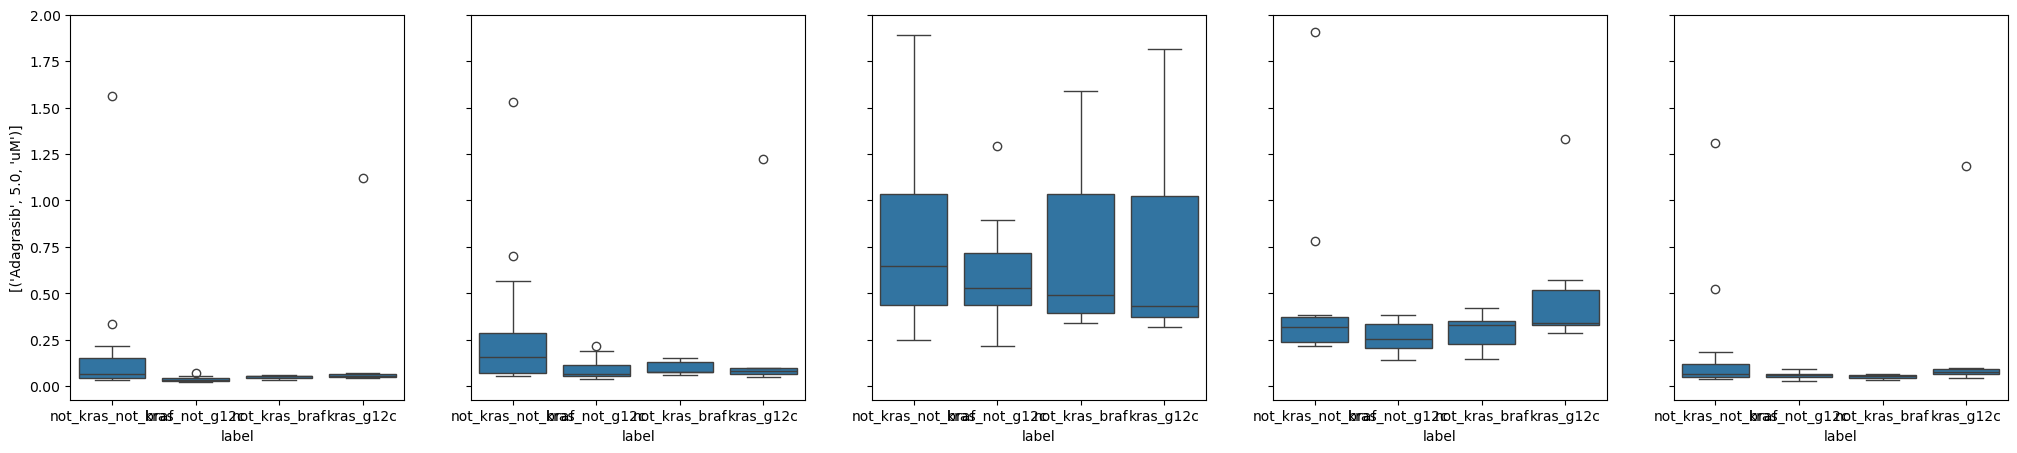

In [9]:
nplot = len(picked_drugs)
fig, axs = plt.subplots(1, nplot, figsize=(nplot*5, 5), sharey=True)
for drug, ax in zip(picked_drugs, axs.flatten()):
	sns.boxplot(x=mse_meta['label'], y=msedf[drug], ax=ax)


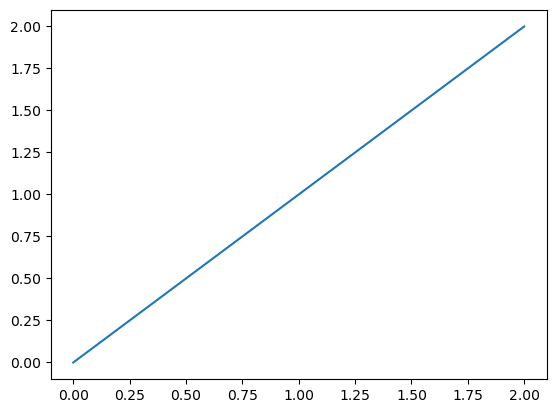

In [10]:
plt.plot([0,1,2], [0,1,2])

In [ ]:
msedf[drug].hist()

In [ ]:
kras_driven = cl_meta.query("Driver_Gene_Symbol == 'KRAS'")
kras_driven_cell_lines = kras_driven['cell_name'].unique()
kras_driven = kras_driven[kras_driven['cell_name'].isin(msedf.columns)]
kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'")
# kras_driven

In [ ]:
g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect == 'p.G12C'").query("Organ == 'Lung'")['cell_name']
not_g12c = kras_driven.query("Driver_ProtEffect_or_CdnaEffect != 'p.G12C'").query("Organ == 'Lung'")['cell_name']
len(g12c), len(not_g12c), not kras

In [ ]:
not_kras_driven = cl_meta.query("cell_name not in @kras_driven_cell_lines")
#drop any cell lines that have BRAF
braf_mutated = cl_meta.query("Driver_Gene_Symbol == 'BRAF'")['cell_name'].unique()
krasNo_brafNo = not_kras_driven.query("cell_name not in @braf_mutated").query("Organ == 'Lung'")['cell_name'].unique()
krasNo_brafNo